<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/notebooks/2-Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training of Neural Networks

##  Goal

In this notebook, we train neural networks (NNs) on simulated photon-counting data for the task of parameter estimation.

This notebook requires a populated `[datapath]\training-trajectories` folder, and will populate a `[datapath]\models` folder.


Each row in the training data $x$ consists on lists of time delays between photo-detection events of the form $D=[\tau_1,\ldots,\tau_N]$.

The target data $y$ consist of the true values of the parameters to be estimated (i.e., the parameters used to simulate the photon-counting data).

This corresponds to $\Delta$ in the 1D parameter estimation case, or a vector with the values $[\Delta,\Omega]$ in the 2D parameter estimation case.

## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import *

from tqdm import tqdm
from tqdm.keras import TqdmCallback

# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())
if isColab:
  from google.colab import files

# We fix the random seed to ensure reproducibility

my_seed_number = 42
# Set the random seed for TensorFlow
tf.random.set_seed(my_seed_number)

# Set the random seed for NumPy (used by TensorFlow for certain operations)
np.random.seed(my_seed_number)

## Setup and requirements

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub.
- Install the custom pacakge

In [3]:
# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())

# Download repository if we are in Colab and install "paramest_nn" package
if isColab:
  print('We are running in Colab. Cloning repository.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

  print('Installing paramest_nn package')
  ! pip install -e .

We are running in Colab. Cloning repository.
Cloning into 'ParamEst-NN'...
remote: Enumerating objects: 420, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 420 (delta 45), reused 32 (delta 30), pack-reused 364
Receiving objects: 100% (420/420), 47.78 MiB | 39.08 MiB/s, done.
Resolving deltas: 100% (240/240), done.
Repository downloaded.
Installing paramest_nn package
Obtaining file:///content
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21

### Import custom packages

In [4]:
from paramest_nn.quantum_tools import *

### Data path

In [5]:
# specify the data path
datapath = '../data/'

# if running in Colab, remove the "../"
if isColab:
    datapath = datapath.split("../")[1]

Create data folder in the datapath if not already present

In [6]:
create_directory(datapath)

Folder already exists.


### Populate data folder with required data

This notebook requires the following populated folder

- `[datapath]/training-trajectories`.

#### Option #1: Downloading the data

The data that was used for the results shown in the paper can be downloaded from [Zenodo](https://zenodo.org/).
You can choose to download this data automatically by setting

 ```python
 download_required = True
 ```

  in the following cell.
This will be done automatically if this notebook is run in Google Colab.


In [7]:
download_required = True

if isColab:
    download_required = True

##### Download link (Mirror 1 - Dropbox)

In [8]:
url_download_training_trajs = "https://www.dropbox.com/scl/fi/xqsofxal5zyoxojudexmi/training-trajectories.zip?rlkey=zbgkc2jd83bwdtl5kj7rli22e&dl=0"

##### Download link (Mirror 2 - Zotero)

Uncomment the following cell if the Dropbox links in Mirror 1 are not operative.

Hosting of this data in Zenodo is guaranteed, although download times might be slower

In [9]:
# url_download_training_trajs = "https://www.dropbox.com/scl/fi/xqsofxal5zyoxojudexmi/training-trajectories.zip?rlkey=zbgkc2jd83bwdtl5kj7rli22e&dl=0"

##### Download data
You may want to go and grab a coffee ☕️

In [10]:
if download_required == True:
    ! wget -q -O training-trajectories.zip --show-progress "$url_download_training_trajs" && unzip -q training-trajectories.zip -d "$datapath" &&  rm training-trajectories.zip


training-trajectori 100%[===================>]   2.76G   116MB/s    in 25s     


#### Option #2: Generate data

The folders can be populated with your own data as follows.

- `[datapath]/training-trajectories/`:     Populated by running the notebook [1-Trajectories_generation.ipynb](https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb)

### Training strategy

We check if there is a TPU available (running in Colab) and set the corresponding strategy to run on TPU. Otherwise, we use the default distribution strategy based on your hardware and environment.

In [11]:
if 'COLAB_TPU_ADDR' in os.environ:
    print("Tensorflow running in TPU")
elif tf.config.experimental.list_physical_devices('GPU'):
    print("Tensorflow running in GPU")
else:
    print("Tensorflow running in CPU")

def setup_strategy():
    if 'COLAB_TPU_ADDR' in os.environ:
        # TPU setup
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("Running on TPU")
        strategy = tf.distribute.TPUStrategy(resolver)
    else:
        strategy = tf.distribute.get_strategy()  # Get the default strategy
    return strategy

Tensorflow running in TPU


## Training 1D Models <a id='1D'> </a>

### Load training data (1D $\Delta$ estimation) <a id='load'></a>

In [12]:
path_tau= datapath + "training-trajectories/1D-delta/taus-Delta-1D.npy"
path_param= datapath +"training-trajectories/1D-delta/delta_rand_list-Delta-1D.npy"

In [13]:
tau_list = np.load(path_tau)
Delta_list = np.load(path_param)

ntraj = len(tau_list)

if len(tau_list)!=len(Delta_list):
  print("ERROR: Dimensions of X (tau_list) and Y (Delta_list) do not match!")
else:
  print(f"{ntraj} trajectories loaded")

4000000 trajectories loaded


Select the number of trajectories that we want to use for the training (equal or smaller to number of trajectories loaded)

In [14]:
ntraj_select = 4000000

tau_list = tau_list[:ntraj_select].astype(np.float32)
Delta_list = Delta_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [15]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, Delta_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

### Model #1: RNN architecture
<a id='RNN'></a>

Define and train the network

In [ ]:
def create_model():
  # Set the RNN
  dropout = 0.
  activation = "relu"
  modelRNN = keras.models.Sequential(
  [keras.layers.LSTM(17,input_shape=[None,1],return_sequences=True, activation=activation,dropout=dropout),
  keras.layers.LSTM(17, return_sequences=False, activation=activation,dropout=dropout),
  keras.layers.Dense(1)]
  )
  return modelRNN

Training details

In [ ]:
epochs = 2000
batch_size = 12800
optimizer = "adam"
loss =  tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Perform training
- If the notebook is run in Colab, it tries to use TPU.
- Otherwise, train in local machine.

In [ ]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelRNN = create_model()
  modelRNN.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

  historyRNN=modelRNN.fit(np.expand_dims(X_train,axis=-1), y_train,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=(np.expand_dims(X_valid,axis=-1), y_valid),
      validation_freq=1
      #,  verbose=0 ,  callbacks=[TqdmCallback(verbose=0)]
      )

Running on TPU
Epoch 1/2000
250/250 [==============================] - 13s 37ms/step - loss: 0.0557 - mean_squared_error: 1.0736 - val_loss: 0.0113 - val_mean_squared_error: 0.1130
Epoch 2/2000
250/250 [==============================] - 6s 22ms/step - loss: 0.0101 - mean_squared_error: 0.1144 - val_loss: 0.0091 - val_mean_squared_error: 0.0757
Epoch 3/2000
250/250 [==============================] - 6s 22ms/step - loss: 0.0087 - mean_squared_error: 0.0694 - val_loss: 0.0085 - val_mean_squared_error: 0.0649
Epoch 4/2000
250/250 [==============================] - 6s 23ms/step - loss: 0.0084 - mean_squared_error: 0.0635 - val_loss: 0.0082 - val_mean_squared_error: 0.0615
Epoch 5/2000
250/250 [==============================] - 6s 23ms/step - loss: 0.0082 - mean_squared_error: 0.0607 - val_loss: 0.0081 - val_mean_squared_error: 0.0595
Epoch 6/2000
250/250 [==============================] - 6s 22ms/step - loss: 0.0080 - mean_squared_error: 0.0592 - val_loss: 0.0079 - val_mean_squared_error: 0

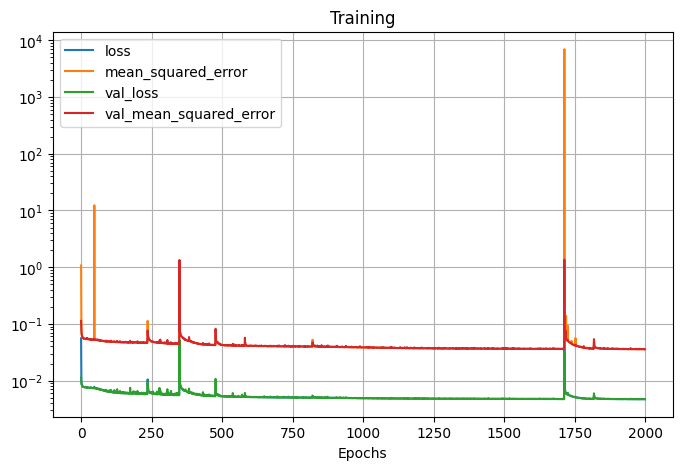

In [ ]:
pd.DataFrame(historyRNN.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training")
plt.grid(True)
plt.yscale("log")
plt.show()


Visualize the predictions made by the model in the validation set

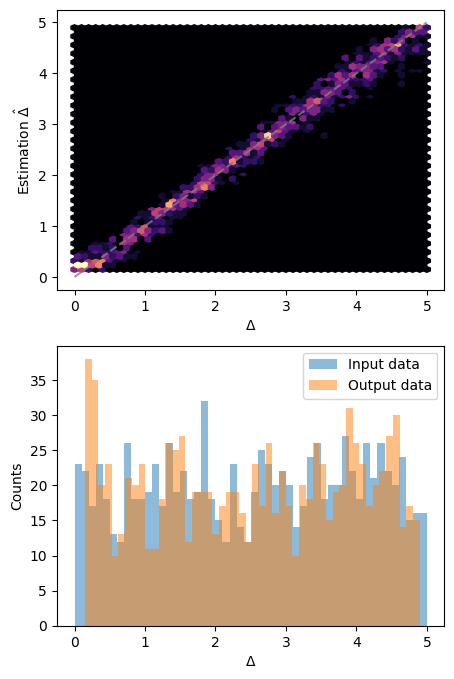

In [ ]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelRNN(x_values)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [ ]:
modelTrainName = f'model-RNN.h5'

save_dir = datapath+"models/1D/"
create_directory(save_dir)
save_path = save_dir + modelTrainName


modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

Directory data/models/1D/ not found: creating...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model #2: Hist-Dense architecture
<a id='Hist'></a>

Define the model


In [22]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Setup the training

In [23]:
  epochs = 1200
  batch_size = 12800
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Training

In [24]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

history=modelHist.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid),
    validation_freq=1)

Running on TPU
Epoch 1/1200
250/250 [==============================] - 11s 32ms/step - loss: 0.0327 - mean_squared_error: 0.2979 - val_loss: 0.0081 - val_mean_squared_error: 0.0817
Epoch 2/1200
250/250 [==============================] - 4s 17ms/step - loss: 0.0075 - mean_squared_error: 0.0744 - val_loss: 0.0070 - val_mean_squared_error: 0.0692
Epoch 3/1200
250/250 [==============================] - 4s 17ms/step - loss: 0.0068 - mean_squared_error: 0.0659 - val_loss: 0.0066 - val_mean_squared_error: 0.0628
Epoch 4/1200
250/250 [==============================] - 4s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0601 - val_loss: 0.0062 - val_mean_squared_error: 0.0569
Epoch 5/1200
250/250 [==============================] - 4s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0559 - val_loss: 0.0061 - val_mean_squared_error: 0.0548
Epoch 6/1200
250/250 [==============================] - 4s 17ms/step - loss: 0.0060 - mean_squared_error: 0.0542 - val_loss: 0.0060 - val_mean_squared_error: 0

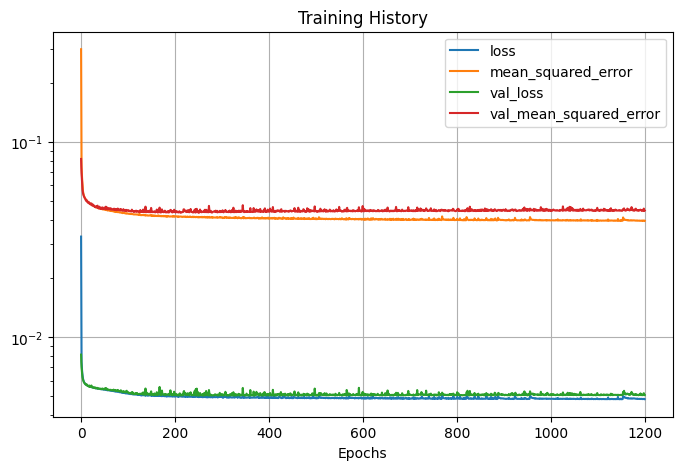

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training History")
plt.grid(True)
plt.yscale("log")
plt.show()

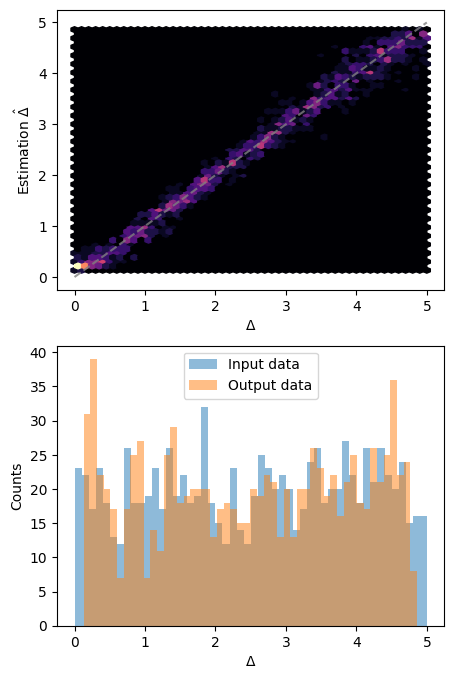

In [26]:
nsel = 1000
x_values = X_valid[np.argsort(y_valid[:nsel])]
output = modelHist.predict(x_values, verbose=False)[:,0]

input = np.sort(y_valid[:nsel])

fig, axes = plt.subplots(nrows = 2, figsize = (5,8))
ax = axes[0]
ax.hexbin(input,output, gridsize=50, cmap = 'magma')
ax.plot(input,input,'--',color="gray",alpha=0.8)
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Estimation $\hat \Delta$")

ax = axes[1]
ax.hist(input,bins = 50, alpha = 0.5, label = "Input data")
ax.hist(output,bins = 50, alpha = 0.5, label = "Output data")
ax.set_xlabel("$\Delta$"); ax.set_ylabel("Counts")
ax.legend()
plt.show()

Save the model

In [28]:
modelTrainName = f'model-Hist.h5'

save_dir = datapath+"models/1D/"
create_directory(save_dir)
save_path = save_dir + modelTrainName


modelHist.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

Folder already exists.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training Hist-Dense models with noise in the y_train

Define the model

In [15]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

ModuleNotFoundError: ignored

Define $\sigma$ interval

In [16]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(sigma_min,sigma_max,nsigma)

Setup the training

In [ ]:
  epochs = 20
  optimizer = "adam"
  loss = tf.keras.losses.MeanSquaredLogarithmicError()
  metrics = ["MeanSquaredError"]

Create callback to save the model of the best epoch during training

In [ ]:
file_dir = datapath+"models/1D/noise-y-train/"
create_directory(file_dir)

def Create_Callback(sigma):
  filepath= file_dir+ 'model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [ ]:
! rm -r "$datapath"models/1D/noise-y-train/*

tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

with strategy.scope():
  model_Prev = tf.keras.models.clone_model(modelHist)
  model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

# First do a very quick training to initialize the weights for later training
sigma = 0.
noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
y_train_noise = np.abs(y_train + noise)
noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
y_valid_noise = np.abs(y_valid + noise_valid)

model_Prev.fit(X_train.astype(np.float32),
                      y_train_noise.astype(np.float32),
                      epochs=2,
                      callbacks=Create_Callback(sigma),
                        batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                        verbose = False)

# Now loop over sigma
history_list = []
for sigma in tqdm(sigma_list):

    # First we create a model cloning the partially trained one
    with strategy.scope():
      model = tf.keras.models.clone_model(model_Prev)
      model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

      # Add noise to data
      noise = np.random.normal(loc=0., scale=sigma, size=len(y_train))
      y_train_noise = np.abs(y_train + noise)
      noise_valid = np.random.normal(loc=0., scale=sigma, size=len(y_valid))
      y_valid_noise = np.abs(y_valid + noise_valid)

      # Fit the model with noisy data
      history = model.fit(X_train.astype(np.float32),
                      y_train_noise.astype(np.float32),
                      epochs=epochs,
                      callbacks=Create_Callback(sigma),
                        batch_size = 1280, validation_data=(X_valid.astype(np.float32), y_valid_noise.astype(np.float32)), validation_freq=1,
                        verbose = False)

      # Store the history of the training
      history_list.append(history)

rm: cannot remove 'data/models/1D/noise-y-train/*': No such file or directory


100%|██████████| 30/30 [02:26<00:00,  4.90s/it]


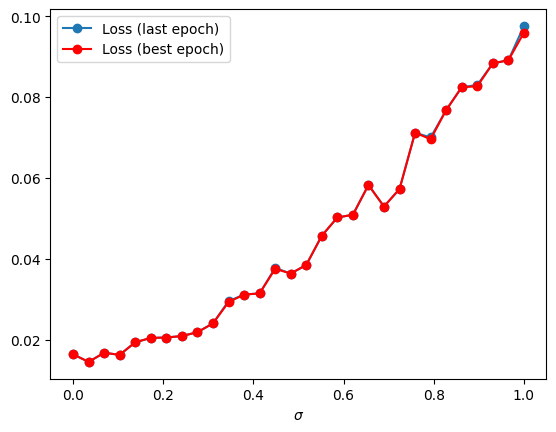

In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

plt.plot(sigma_list,val_loss_list[:,-1],'-o', label = "Loss (last epoch)")
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro', label = "Loss (best epoch)")
plt.legend()
plt.xlabel("$\sigma$"); plt.ylabel("")
plt.show()

If we are in Colab, we zip and download the files

In [ ]:
if isColab:
  !zip -rq models-sigma-y-train.zip "$datapath"models/1D/noise-y-train/
  files.download("models-sigma-y-train.zip")

  adding: data/models/1D/noise-y-train/ (stored 0%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.9310344827586207.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_1.0.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.8275862068965517.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.7931034482758621.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma_0.10344827586206896.hdf5 (deflated 11%)
  adding: data/models/1D/noise-y-train/model_best_Hist-sigma

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Training Hist models with noise in the x_train

Define the model

In [ ]:
from src.custom_layers import MyHistogramLayer_Sigmoid

nbins = 700
taumax = 100
width = taumax/nbins


def create_model_Hist():
  # Set the model
  activation = "relu"
  droprate = 0.
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
      keras.layers.Dense(1)
   ]
  )
  return modelHist

Define $\sigma$ interval

In [ ]:
sigma_min = 0.;sigma_max = 1.;nsigma = 30; sigma_list = np.linspace(0,sigma_max,nsigma)

Setup the training

In [ ]:
epochs = 10
batch_size = 1280
#optimizer = tf.keras.optimizers.legacy.Adam(  learning_rate=0.0001)
optimizer = "adam"
loss = tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Define Callback to save the model of the best epoch during training

In [ ]:
file_dir = datapath+"models/1D/noise-x-train/"
create_directory(file_dir)

def Create_Callback(sigma):
  filepath= file_dir+ 'model_best_Hist-sigma_'+str(sigma)+'.hdf5'

  checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                              monitor='val_loss',
                              verbose=0,
                              save_best_only=True,
                              mode='min')

  callbacks = [checkpoint]
  return callbacks

Loop over $\sigma$

In [ ]:
# Clean the "data/models/noise-x-train" folder
! rm -r "$datapath"models/1D/noise-x-train


tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist()
  modelHist.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

with strategy.scope():
  model_Prev = tf.keras.models.clone_model(modelHist)
  model_Prev.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

# First do a very quick training to initialize the weights for later training
sigma = 0.
model_Prev.fit(X_train.astype(np.float32),
                      y_train.astype(np.float32),
                      epochs=2,
                      callbacks=Create_Callback(sigma),
                        batch_size = batch_size, validation_data=(X_valid.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                        verbose = False)

# Now loop over sigma
history_list = []
for sigma in tqdm(sigma_list):

  # First we create a model cloning the partially trained one
  with strategy.scope():
    model = tf.keras.models.clone_model(model_Prev)
    model.compile(optimizer= optimizer, loss=loss, metrics=[metrics])

  # Add noise to x- data (delays)
  noise = np.random.normal(loc=0., scale=sigma, size=tau_list.shape)
  tau_list_noise = (tau_list + noise).clip(min=0.001)
  #Proper shape to x-data
  X_train_full_Hist = tau_list_noise
  lenTrain=int(0.8*len(X_train_full))
  X_train_Hist, X_valid_Hist = X_train_full_Hist[:lenTrain], X_train_full_Hist[lenTrain:]

  # Fit the model with noisy data
  history = model.fit(X_train_Hist.astype(np.float32),
                  y_train.astype(np.float32),
                  epochs=epochs,
                  callbacks=Create_Callback(sigma),
                    batch_size = batch_size, validation_data=(X_valid_Hist.astype(np.float32), y_valid.astype(np.float32)), validation_freq=1,
                    verbose = False)

    # Store the history of the training
  history_list.append(history)

100%|██████████| 30/30 [01:47<00:00,  3.59s/it]


In [ ]:
histories = [pd.DataFrame(result.history) for result in history_list]
val_loss_list = np.array([history.val_loss for history in histories])

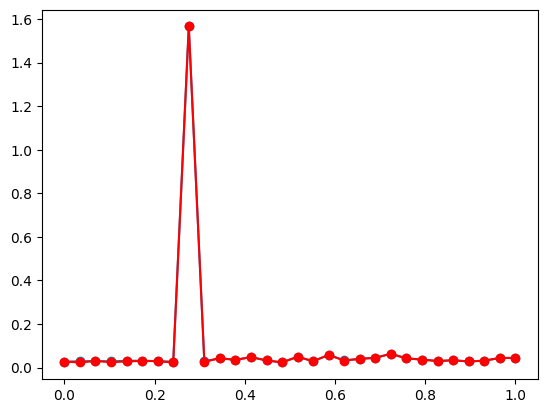

In [ ]:
plt.plot(sigma_list,val_loss_list[:,-1],'-o')
plt.plot(sigma_list,np.min(val_loss_list,axis=1),'-ro')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

In [ ]:
!zip -rq models-sigma-x-train.zip "$datapath"models/1D/noise-x-train/

from google.colab import files
files.download("models-sigma-x-train.zip")

  adding: data/models/1D/noise-x-train/ (stored 0%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.48275862068965514.hdf5 (deflated 12%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.9310344827586207.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.20689655172413793.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_1.0.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.8620689655172413.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.8275862068965517.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.6551724137931034.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.7931034482758621.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma_0.10344827586206896.hdf5 (deflated 11%)
  adding: data/models/1D/noise-x-train/model_best_Hist-sigma

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training 2D Models <a id='1D'> </a>

### Load data <a id='load'></a>

#### Training data: 2D  estimation [$\Delta$,$\Omega$]

- If this notebook is run online in Google Colab, we download the data from the online repo and the necessary src files.
- Otherwise, we accesss to the local data in `data/training`

In [ ]:
path_tau= datapath+"training-trajectories/2D-delta-omega/taus-2D.npy"
path_param= datapath+"/training-trajectories/2D-delta-omega/param_rand_list-2D.npy"

In [ ]:
tau_list = np.load(path_tau)
param_list = np.load(path_param)

Select number of trajectories that we will use for the training

In [ ]:
ntraj_select = 4000
tau_list = tau_list[:ntraj_select].astype(np.float32)
param_list = param_list[:ntraj_select].astype(np.float32)

- We split the data set: 80% training, 20% validation.

- We do not shuffle the data since the trajectories were already generated randomly

In [ ]:
njumps = tau_list.shape[1]

# Set data generated from Monte Carlo
X_train_full, y_train_full = tau_list, param_list

lenTrain=int(0.8*len(X_train_full))
X_train, X_valid = X_train_full[:lenTrain], X_train_full[lenTrain:]
y_train, y_valid = y_train_full[:lenTrain], y_train_full[lenTrain:]

### Model: Hist-Dense Architecture

In [ ]:
from paramest_nn.custom_layers import MyHistogramLayer_Sigmoid

Define the model

In [ ]:
# Custom-made histogram function
nbins = 700
taumax = 100
width = taumax/nbins

def create_model_Hist2D():
  # Set the model
  activation = "relu"
  droprate = 0
  modelHist = keras.models.Sequential(
  [
  MyHistogramLayer_Sigmoid(nbins, taumax, trainable = False),
  keras.layers.Dense(100, activation=activation),
   keras.layers.Dropout(droprate),
  keras.layers.Dense(50, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(30, activation=activation),
   keras.layers.Dropout(droprate),
   keras.layers.Dense(20, activation=activation),
   keras.layers.Dropout(droprate),
   keras.layers.Dense(10, activation=activation),
   keras.layers.Dropout(droprate),
     keras.layers.Dense(2)
   ]
  )
  return modelHist

Setup training

In [ ]:
epochs = 1200
batch_size = 12800
optimizer = "adam"
loss = tf.keras.losses.MeanSquaredLogarithmicError()
metrics = ["MeanSquaredError"]

Train

In [ ]:
tf.keras.backend.clear_session()
strategy = setup_strategy()

with strategy.scope():
  modelHist = create_model_Hist2D()
  modelHist.compile(
      optimizer= optimizer,
      loss=loss,
            metrics=[metrics]
      )

history=modelHist.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_valid, y_valid))


Running on TPU
Epoch 1/1200
250/250 [==============================] - 9s 26ms/step - loss: 0.0556 - mean_squared_error: 0.4385 - val_loss: 0.0081 - val_mean_squared_error: 0.0827
Epoch 2/1200
250/250 [==============================] - 4s 15ms/step - loss: 0.0074 - mean_squared_error: 0.0761 - val_loss: 0.0070 - val_mean_squared_error: 0.0717
Epoch 3/1200
250/250 [==============================] - 4s 15ms/step - loss: 0.0068 - mean_squared_error: 0.0685 - val_loss: 0.0066 - val_mean_squared_error: 0.0656
Epoch 4/1200
250/250 [==============================] - 4s 15ms/step - loss: 0.0064 - mean_squared_error: 0.0632 - val_loss: 0.0063 - val_mean_squared_error: 0.0609
Epoch 5/1200
250/250 [==============================] - 4s 16ms/step - loss: 0.0062 - mean_squared_error: 0.0589 - val_loss: 0.0061 - val_mean_squared_error: 0.0573
Epoch 6/1200
250/250 [==============================] - 4s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0554 - val_loss: 0.0059 - val_mean_squared_error: 0.

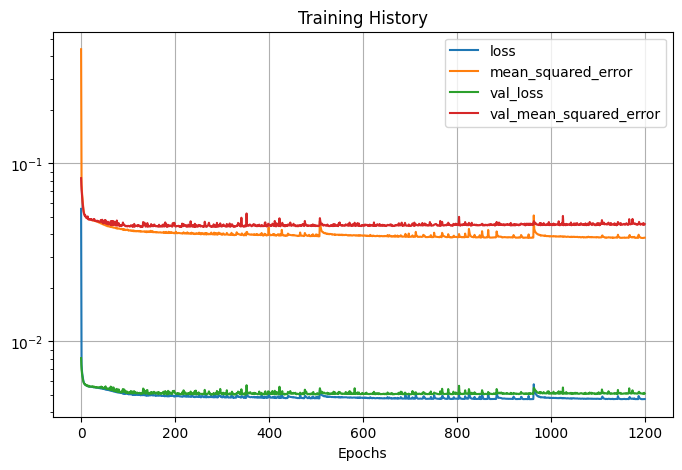

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.xlabel("Epochs")
plt.title("Training History")
plt.grid(True)
plt.yscale("log")
plt.show()

In [ ]:
modelTrainName = f'model-Hist-Dense-2D.h5'


save_dir = datapath+"models/2D/"
create_directory(save_dir)
save_path = save_dir + modelTrainName


modelRNN.save(save_path)

if isColab:
    from google.colab import files
    files.download(save_path)

Folder already exists.


UnavailableError: ignored